In [1]:
# Setup of libraries, mounting the Google Drive etc.

import os
import sys
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf

import utils
import IPython

print('The current working directory is:', os.getcwd())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
The current working directory is: /content/gdrive/My Drive/Colab Notebooks


## Define the parameters
... meaning paramters like which dataset to train on, batch size and so on and so forth

In [0]:
DATASET_NAME = 'geolife'

setup_string = 'GRU-1024_TD-Dense-3_{dataset}_64_100_adam_mae_default'.format(dataset=DATASET_NAME)

In [3]:
setup_string

'GRU-1024_TD-Dense-3_geolife_64_100_adam_mae_default'

## Read the dataset from `.pkl` file


In [4]:
df = pd.read_pickle('datasets/{name}.pkl'.format(name=DATASET_NAME))
df.head()

latitude   longitude            trip
user time                                                      
0    2008-10-23 02:53:04  39.984702  116.318417  20081023025304
     2008-10-23 02:53:10  39.984683  116.318450  20081023025304
     2008-10-23 02:53:15  39.984686  116.318417  20081023025304
     2008-10-23 02:53:20  39.984688  116.318385  20081023025304
     2008-10-23 02:53:25  39.984655  116.318263  20081023025304

## Convert the dataset to a mapping of users to the strings of their movements

In [5]:
df = utils.records_to_user_geolcation_2(df)
df.head()

user
0    [[277962045.0, 116.318417, 39.984702], [277962...
1    [[277972846.0, 116.319236, 39.984094], [277972...
2    [[277997584.0, 116.338967, 39.927938], [277997...
3    [[278016395.0, 116.326752, 39.999844], [278016...
4    [[278016393.0, 116.327149, 39.999974], [278016...
dtype: object

## Concatenate all user strings of data to one complete string of all

In [6]:
data = utils.user_geolocation_to_single_sequence(df)

print(data.shape)
print()
print(data)

(24876978, 3)

[[2.77962045e+08 1.16318417e+02 3.99847020e+01]
 [2.77962051e+08 1.16318450e+02 3.99846830e+01]
 [2.77962056e+08 1.16318417e+02 3.99846860e+01]
 ...
 [2.58697843e+08 1.11710667e+02 4.09124667e+01]
 [2.58697869e+08 1.11711317e+02 4.09115167e+01]
 [2.58697881e+08 1.11711617e+02 4.09109333e+01]]


## Convert the data to 32-bit floats
This is to correct an error I got earlier. Apparently the GRU layers can't handle 64-bit integers (doubles) as input.

In [7]:
print('Before: ', data.dtype)

Before:  float64


In [0]:
data = data.astype(np.float32)

In [9]:
print('After: ', data.dtype)

After:  float32


## Reshape and -order the data for input into the model (including X and y split)


In [10]:
data.shape

(24876978, 3)

In [11]:
BATCH_SIZE = 64
SEQ_LENGTH = 100

n_batches, X, y = utils.reshape_single_sequence_to_rnn_Xy(data, BATCH_SIZE, SEQ_LENGTH)

print('X:', X.shape)
print('y:', y.shape)

X: (248768, 100, 3)
y: (248768, 100, 3)


## Split into training and validations sets

In [12]:
n_train = int(n_batches * 0.8) * BATCH_SIZE
X_train = X[:n_train]
y_train = y[:n_train]
X_val = X[n_train:]
y_val = y[n_train:]

print('Train:', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)

Train: (198976, 100, 3) (198976, 100, 3)
Validation: (49792, 100, 3) (49792, 100, 3)


## Standardisation
All three features in the data are scaled to have a `mean = 0` and a `standard deviation = 1`.

The Scaler is also saved to disk, so it can later be resued in a different Notebook.

The Scaler is fitted only to the training data, not the validation / test data.

In [13]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(np.array([X_train[:, :, 0].reshape(-1), X_train[:, :, 1].reshape(-1), X_train[:, :, 2].reshape(-1)]).transpose())

print('Means: %f %f %f' % (scaler.mean_[0], scaler.mean_[1], scaler.mean_[2]))
print('Standard deviations: %f %f %f' % (scaler.var_[0], scaler.var_[1], scaler.var_[2]))

Means: 299716572.533831 111.747559 38.970289
Standard deviations: 1026133118156800.000000 854.296631 17.753506


In [14]:
with open('scalers/citybased_rnn_2/' + setup_string + '.pkl', 'wb') as file:
    pickle.dump(scaler, file)
    print('Scaler saved')

Scaler saved


In [0]:
for i in range(len(X_train)):
    X_train[i] = scaler.transform(X_train[i])
    y_train[i] = scaler.transform(y_train[i])

for i in range(len(X_val)):
    X_val[i] = scaler.transform(X_val[i])
    y_val[i] = scaler.transform(y_val[i])

In [16]:
print(X_train.shape)
print()
print(X_train[:1, :6])
print(X_val[:1, :6])

(198976, 100, 3)

[[[-0.6791219   0.15638451  0.24075371]
  [-0.6791219   0.15638556  0.2407492 ]
  [-0.6791219   0.15638451  0.24075009]
  [-0.6791219   0.15638322  0.24075009]
  [-0.6791209   0.15637903  0.24074195]
  [-0.6791209   0.15637094  0.24073198]]]
[[[-0.6563626   0.15702742  0.22688098]
  [-0.6563626   0.15702717  0.22688371]
  [-0.6563626   0.1570269   0.22687918]
  [-0.6563626   0.15702586  0.22687647]
  [-0.6563616   0.15702663  0.22687556]
  [-0.6563616   0.15702717  0.22687374]]]


## Build the model

In [ ]:
def build_model(batch_size):
    seq_input = tf.keras.layers.Input(shape=(None, 3), name='seq_input')
    
    recurrent = tf.keras.layers.GRU(1024, return_sequences=True, stateful=True,
                                    input_shape=(None, 3), batch_size=batch_size)
    
    time = tf.keras.layers.Dense(1, activation='relu')
    position = tf.keras.layers.Dense(2)
    record = tf.keras.layers.concatenate([time, position])
    
    sequence_output = tf.keras.layers.TimeDistributed(record)(recurrent)
    
    return tf.keras.models.Model(inputs=seq_input, outputs=sequence_output)

In [0]:
def build_model(batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(1024, return_sequences=True, stateful=True, input_shape=(None, 3), batch_size=batch_size),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3))
    ])
    return model

In [18]:
model = build_model(batch_size=BATCH_SIZE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (64, None, 1024)          3158016   
_________________________________________________________________
time_distributed (TimeDistri (64, None, 3)             3075      
Total params: 3,161,091
Trainable params: 3,161,091
Non-trainable params: 0
_________________________________________________________________


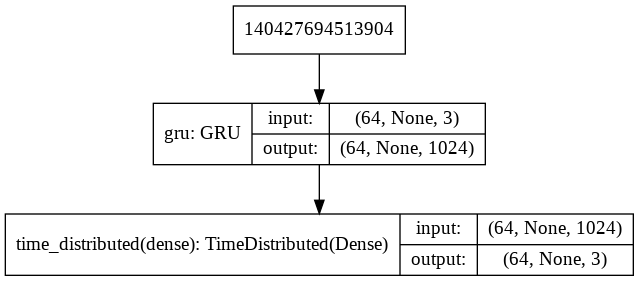

In [19]:
tf.keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

## Test the model's output (before training)

In [20]:
model.input

<tf.Tensor 'gru_input:0' shape=(64, ?, 3) dtype=float32>

In [21]:
# Test the shape of the output
test_batch = X[:BATCH_SIZE]
print('Input batch:', test_batch.shape)
test_predictions = model.predict(test_batch, batch_size=BATCH_SIZE)

print('Output batch:', test_predictions.shape)

model.reset_states()

Input batch: (64, 100, 3)
Output batch: (64, 100, 3)


In [0]:
test_batch = scaler.inverse_transform(test_batch)
test_predictions = scaler.inverse_transform(test_predictions)

In [23]:
print('Input: \n', test_batch[0, 0], test_batch[0, 1], test_batch[0, 2], '...')
print()
print('Next Predictions: \n', test_predictions[0, 0], test_predictions[0, 1], test_predictions[0, 2], '...')

Input: 
 [2.7796205e+08 1.1631842e+02 3.9984703e+01] [2.7796205e+08 1.1631845e+02 3.9984684e+01] [2.7796205e+08 1.1631842e+02 3.9984688e+01] ...

Next Predictions: 
 [2.9912864e+08 1.1166857e+02 3.9038559e+01] [2.9877418e+08 1.1166369e+02 3.9062824e+01] [2.9854272e+08 1.1168230e+02 3.9069340e+01] ...


## Training

In [0]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [0]:
# Folder for the architecture
# Name: List of the layers connected to the parameters by '-',
#       dataset that the network was trained on,
#       batch size,
#       sequence length,
#       optimiser,
#       loss function,
#       learning rate,
#       epoch the checkpoint is from
checkpoint_path = 'checkpoints/citybased_rnn_2/' + setup_string + '_{epoch:02d}.h5'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path)

In [26]:
hist = model.fit(X_train, y_train, epochs=30, batch_size=BATCH_SIZE, shuffle=False, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Train on 198976 samples, validate on 49792 samples
Epoch 1/30
198976/198976 [==============================] - 1195s 6ms/step - loss: 0.0081 - val_loss: 0.0049
Epoch 2/30
198976/198976 [==============================] - 1195s 6ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 3/30
198976/198976 [==============================] - 1196s 6ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 4/30
198976/198976 [==============================] - 1196s 6ms/step - loss: 0.0032 - val_loss: 0.0058
Epoch 5/30
198976/198976 [==============================] - 1197s 6ms/step - loss: 0.0029 - val_loss: 0.0061
Epoch 6/30
198976/198976 [==============================] - 1193s 6ms/step - loss: 0.0051 - val_loss: 0.0063
Epoch 7/30
198976/198976 [==============================] - 1190s 6ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 8/30
198976/198976 [==============================] - 1190s 6ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 9/30
198976/198976 [==============================] - 1191s 6ms/step - 

## Save and plot the history
The history holds information on loss and validiation loss during training.

In [27]:
with open('histories/citybased_rnn_2/' + setup_string + '_30.pkl', 'wb') as file:
    pickle.dump(hist.history, file)
    print('History saved')

History saved


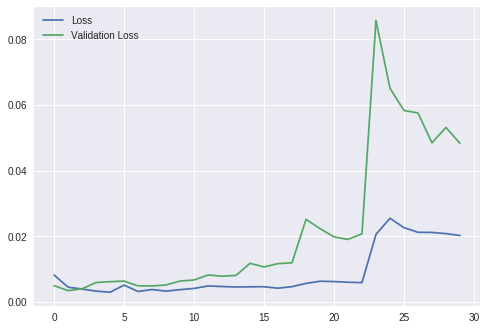

In [28]:
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

## Load and prepare the trained model for generating data

In [0]:
loaded_model = tf.keras.models.load_model('checkpoints/citybased_rnn_2/GRU-1024_TD-Dense-3_cabspotting_64_100_adam_mae_default_05.h5')

In [0]:
model = build_model(batch_size=1)

weights = loaded_model.get_weights()
model.set_weights(weights)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (1, None, 1024)           3158016   
_________________________________________________________________
time_distributed_1 (TimeDist (1, None, 3)              3075      
Total params: 3,161,091
Trainable params: 3,161,091
Non-trainable params: 0
_________________________________________________________________


## Generate geolocation data of one entity using the trained model
In the end the generated data is saved to disk in order to be reused from a different notebook.

In [0]:
N_GENERATE = 1000

start = [324.0, -122.390085, 37.789910]    # Google Offices in San Francisco: 37.789910, -122.390085
generated = np.array([start]).astype(np.float32)

model.reset_states()

for i in range(1, N_GENERATE):
    input = generated[-1:]
    input = scaler.transform(input)
    input = np.array([input])
    
    prediction = model.predict(input, batch_size=1)
    
    prediction = np.squeeze(prediction, axis=0)
    prediction = scaler.inverse_transform(prediction)
    
    generated = np.concatenate([generated, prediction])

In [0]:
generated.shape

(1000, 3)

In [0]:
generated

array([[ 3.24000000e+02, -1.22390083e+02,  3.77899094e+01],
       [-3.02492656e+04, -1.22387428e+02,  3.77959785e+01],
       [-5.41318281e+04, -1.22385445e+02,  3.78016281e+01],
       ...,
       [-1.29628850e+06, -1.22439728e+02,  3.76924286e+01],
       [-1.29628400e+06, -1.22439728e+02,  3.76924057e+01],
       [-1.29627975e+06, -1.22439728e+02,  3.76923828e+01]], dtype=float32)

In [0]:
with open('generated/citybased_rnn_2/test_00.pkl', 'wb') as file:
    pickle.dump(generated, file)
    print('Generated data saved')

Generated data saved
